# Neurons rehablitation

In [23]:
import torch.nn as nn
import scfocus
import scanpy as sc
import pandas as pd
import numpy as np
import joblib
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
cm = 1/2.54
sc.set_figure_params(figsize=(5*cm,5*cm),dpi=300,fontsize=10,frameon=False)

In [10]:
adata = joblib.load('adata')

adata

AnnData object with n_obs × n_vars = 82093 × 22806
    obs: 'replicate', 'label', 'global_cell_type', 'cell_type', 'batch', 'name_snn_res.0.1', 'name_snn_res.0.5', 'name_snn_res.1', 'name_snn_res.2', 'name_snn_res.3', 'name_snn_res.0.01', 'barcode'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [400]:
sc.pp.neighbors(adata, n_pcs=15)
sc.tl.umap(adata)

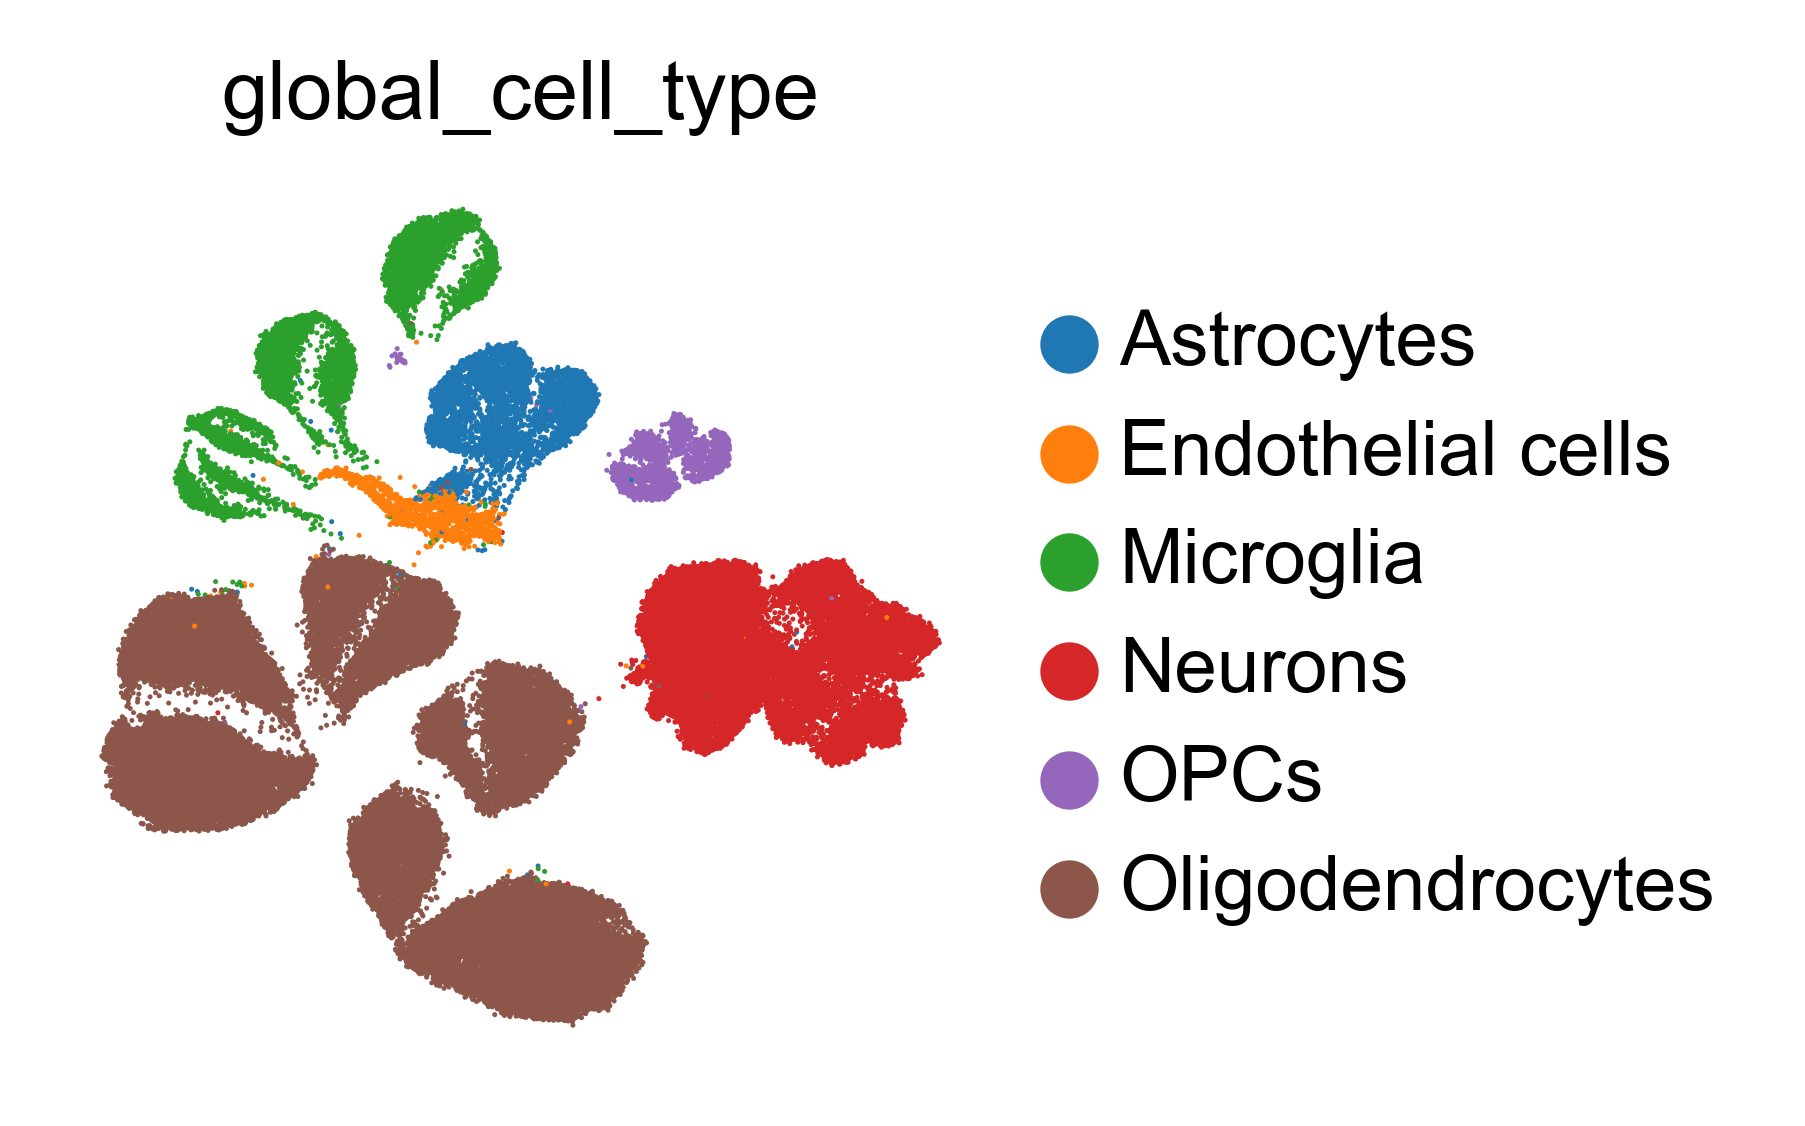

In [401]:
sc.pl.umap(adata, color='global_cell_type')

In [157]:
adata1 = adata[adata.obs['global_cell_type']=='Neurons']

In [402]:
sc.pp.neighbors(adata1)
sc.tl.umap(adata1)

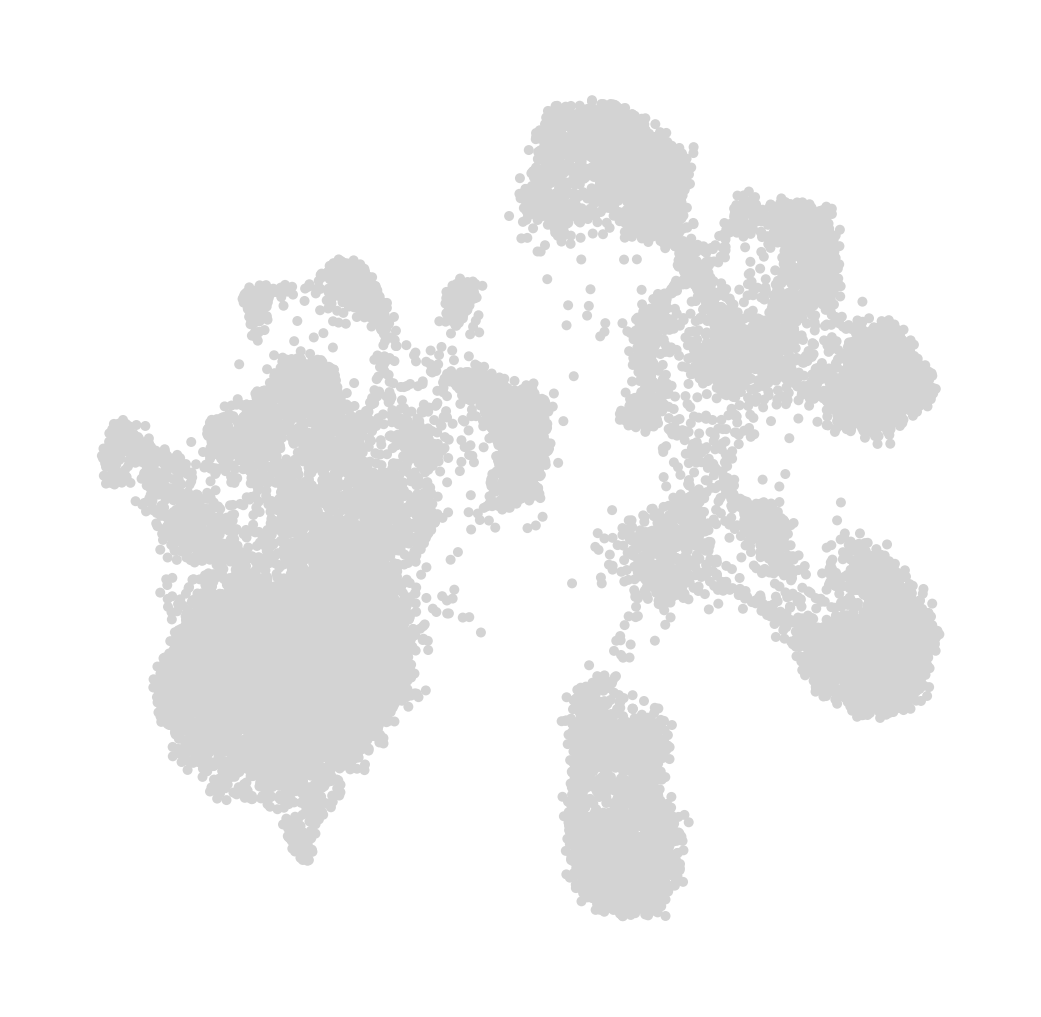

In [403]:
sc.pl.umap(adata1)

In [404]:
pd.DataFrame(adata1.obsm['X_umap']).to_csv('Neurons.csv')

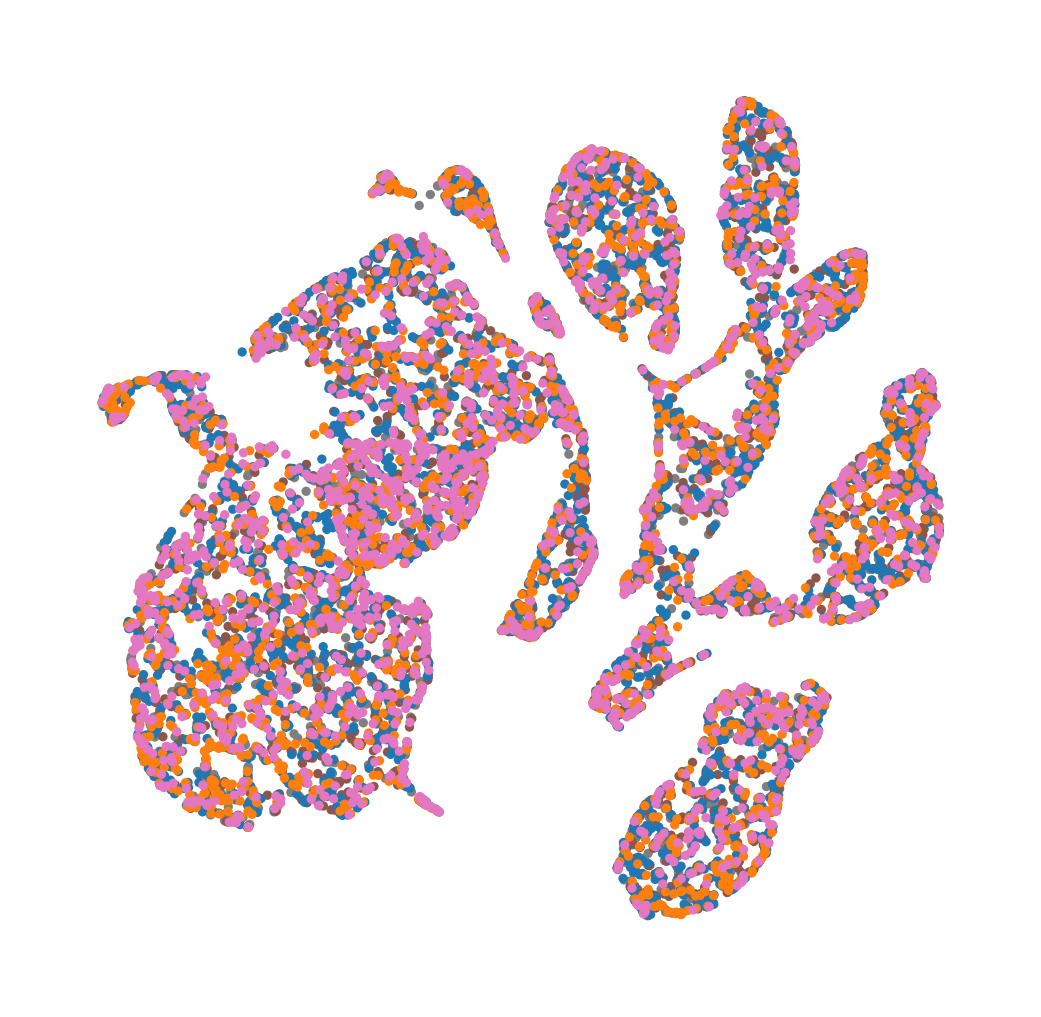

In [292]:
sc.pl.umap(adata1, color='label', groups=['EESREHAB','EESREHAB->EES','SCI','SCI->EES::walking','Uninjured']
           ,title='',legend_loc=None,s=5,na_color='w')

In [296]:
batches = ['EESREHAB','EESREHAB->EES','SCI','SCI->EES::walking','Uninjured']

In [297]:
mask = adata1.obs['label'].isin(batches)

In [ ]:
with sns.axes_style('ticks'):
    fig = plt.figure(figsize=(1.5,2))
    sns.barplot(y=np.arange(5),x=np.unique(adata1.obs['label'][mask], return_counts=True)[1],orient='horizonal', palette=[lut[c] for c in batches],zorder=0)
    ax = plt.gca()
    ax.set_yticklabels(batches, fontdict={'ha':'left'},zorder=10)
    ax.tick_params(axis='y',pad=-4,zorder=10,left=False)
    ax.spines[['right','top']].set_visible(False)

In [ ]:
focus = scfocus.focus(f, n=6, max_steps=3, pct_samples=.01).meta_focusing(3)

In [181]:
focus.merge_fp2()

mfp = focus.mfp[0]

for i in range(mfp.shape[1]):
    
    adata1.obs[f'f{i}'] = mfp[:, i]

In [ ]:
sc.pl.umap(adata1, color=[f'f{i}' for i in range(mfp.shape[1])], cmap='viridis')

In [ ]:
adata1.obsm['X_focus'] = adata1.obs[[f'f{i}' for i in range(11)]].values

sc.pp.neighbors(adata1, use_rep='X_focus')

sc.tl.umap(adata1, min_dist=.2)

In [ ]:
sc.pl.umap(adata1, color=[f'f{i}' for i in range(mfp.shape[1])])

In [ ]:
df = pd.DataFrame(mfp, index=adata1.obs_names)

df['label'] = adata1.obs['label']

df1 = df.groupby('label').mean()

df1 = df1[np.argsort(np.argmax(df1, axis=0))]

from sklearn.preprocessing import StandardScaler

df1 = pd.DataFrame(StandardScaler().fit_transform(df1.values), columns=df1.columns,index=df1.index)

In [235]:
df1.iloc[[0,1,5,6,7],:]

,5,2,3,6,10,0,1,4,7,8,9
label,,,,,,,,,,,
EESREHAB,0.953187,0.460945,0.770499,0.135323,0.911620,-0.953429,-1.076216,-1.072505,-1.087325,-1.053058,-1.051158
EESREHAB->EES,-1.178678,-1.316954,-1.385333,-1.306731,-1.336194,0.627897,0.704716,0.706257,0.529541,0.674822,0.702057
SCI,0.914232,-0.451847,1.273081,1.500645,0.961419,-1.345898,-0.811159,-0.898600,-0.371421,-1.091850,-1.029250
SCI->EES::walking,-1.944437,-1.469438,-1.396348,0.228132,-1.774489,1.752751,2.215645,2.167080,2.367716,2.027430,2.080167
Uninjured,0.372845,0.171850,0.076698,-0.572494,0.228553,-0.492576,-0.644306,-0.622034,-0.759408,-0.570870,-0.591954


In [ ]:
adata1.obs['F1'] = adata1.obs[['f0','f1','f4','f7','f8','f9']].mean(axis=1)

adata1.obs['F_2'] = adata1.obs[['f5','f2','f3','f6','f10']].mean(axis=1)

In [277]:
del adata1.obs['F2']

In [278]:
import gc

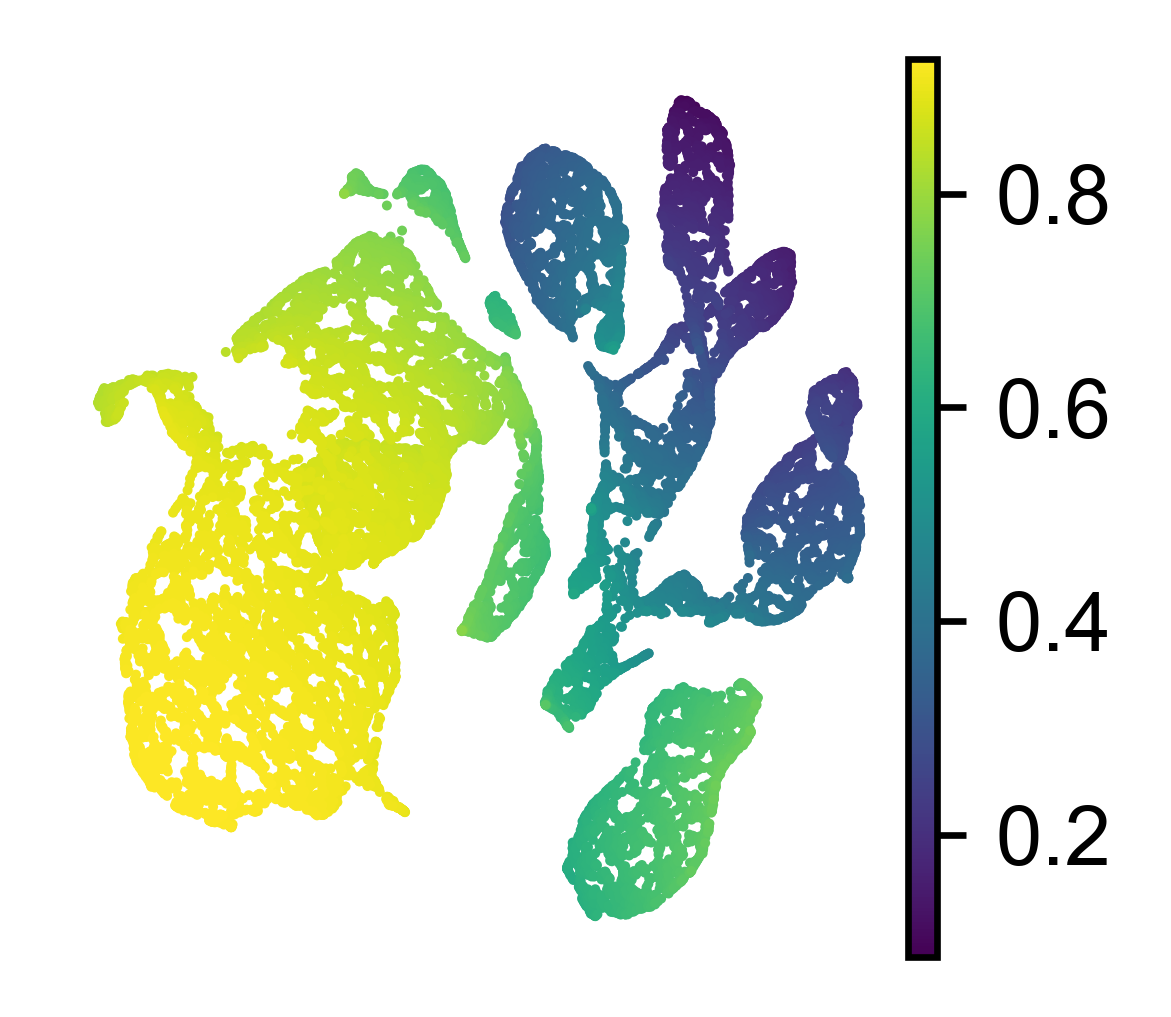

In [276]:
sc.pl.umap(adata1, color='F1', title='', show=False)
plt.savefig(f'REHAB1.png', dpi=1000, bbox_inches='tight', transparent=True)

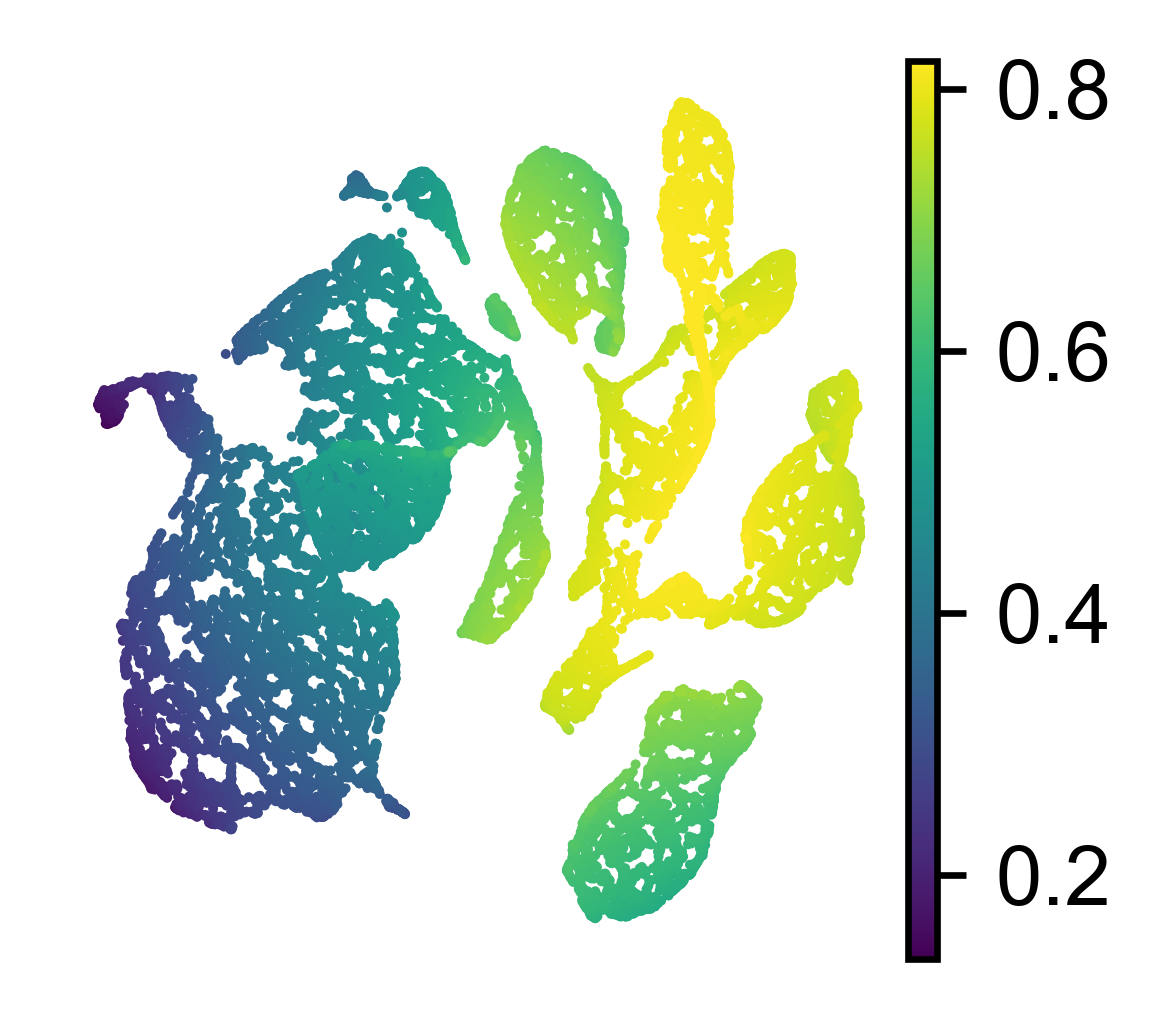

In [282]:
sc.pl.umap(adata1, color='F_2', title='', show=False)
plt.savefig(f'REHAB2.png', dpi=1000, bbox_inches='tight', transparent=True)

In [290]:
lut = dict(zip(adata1.obs['label'].cat.categories, adata1.uns['label_colors']))

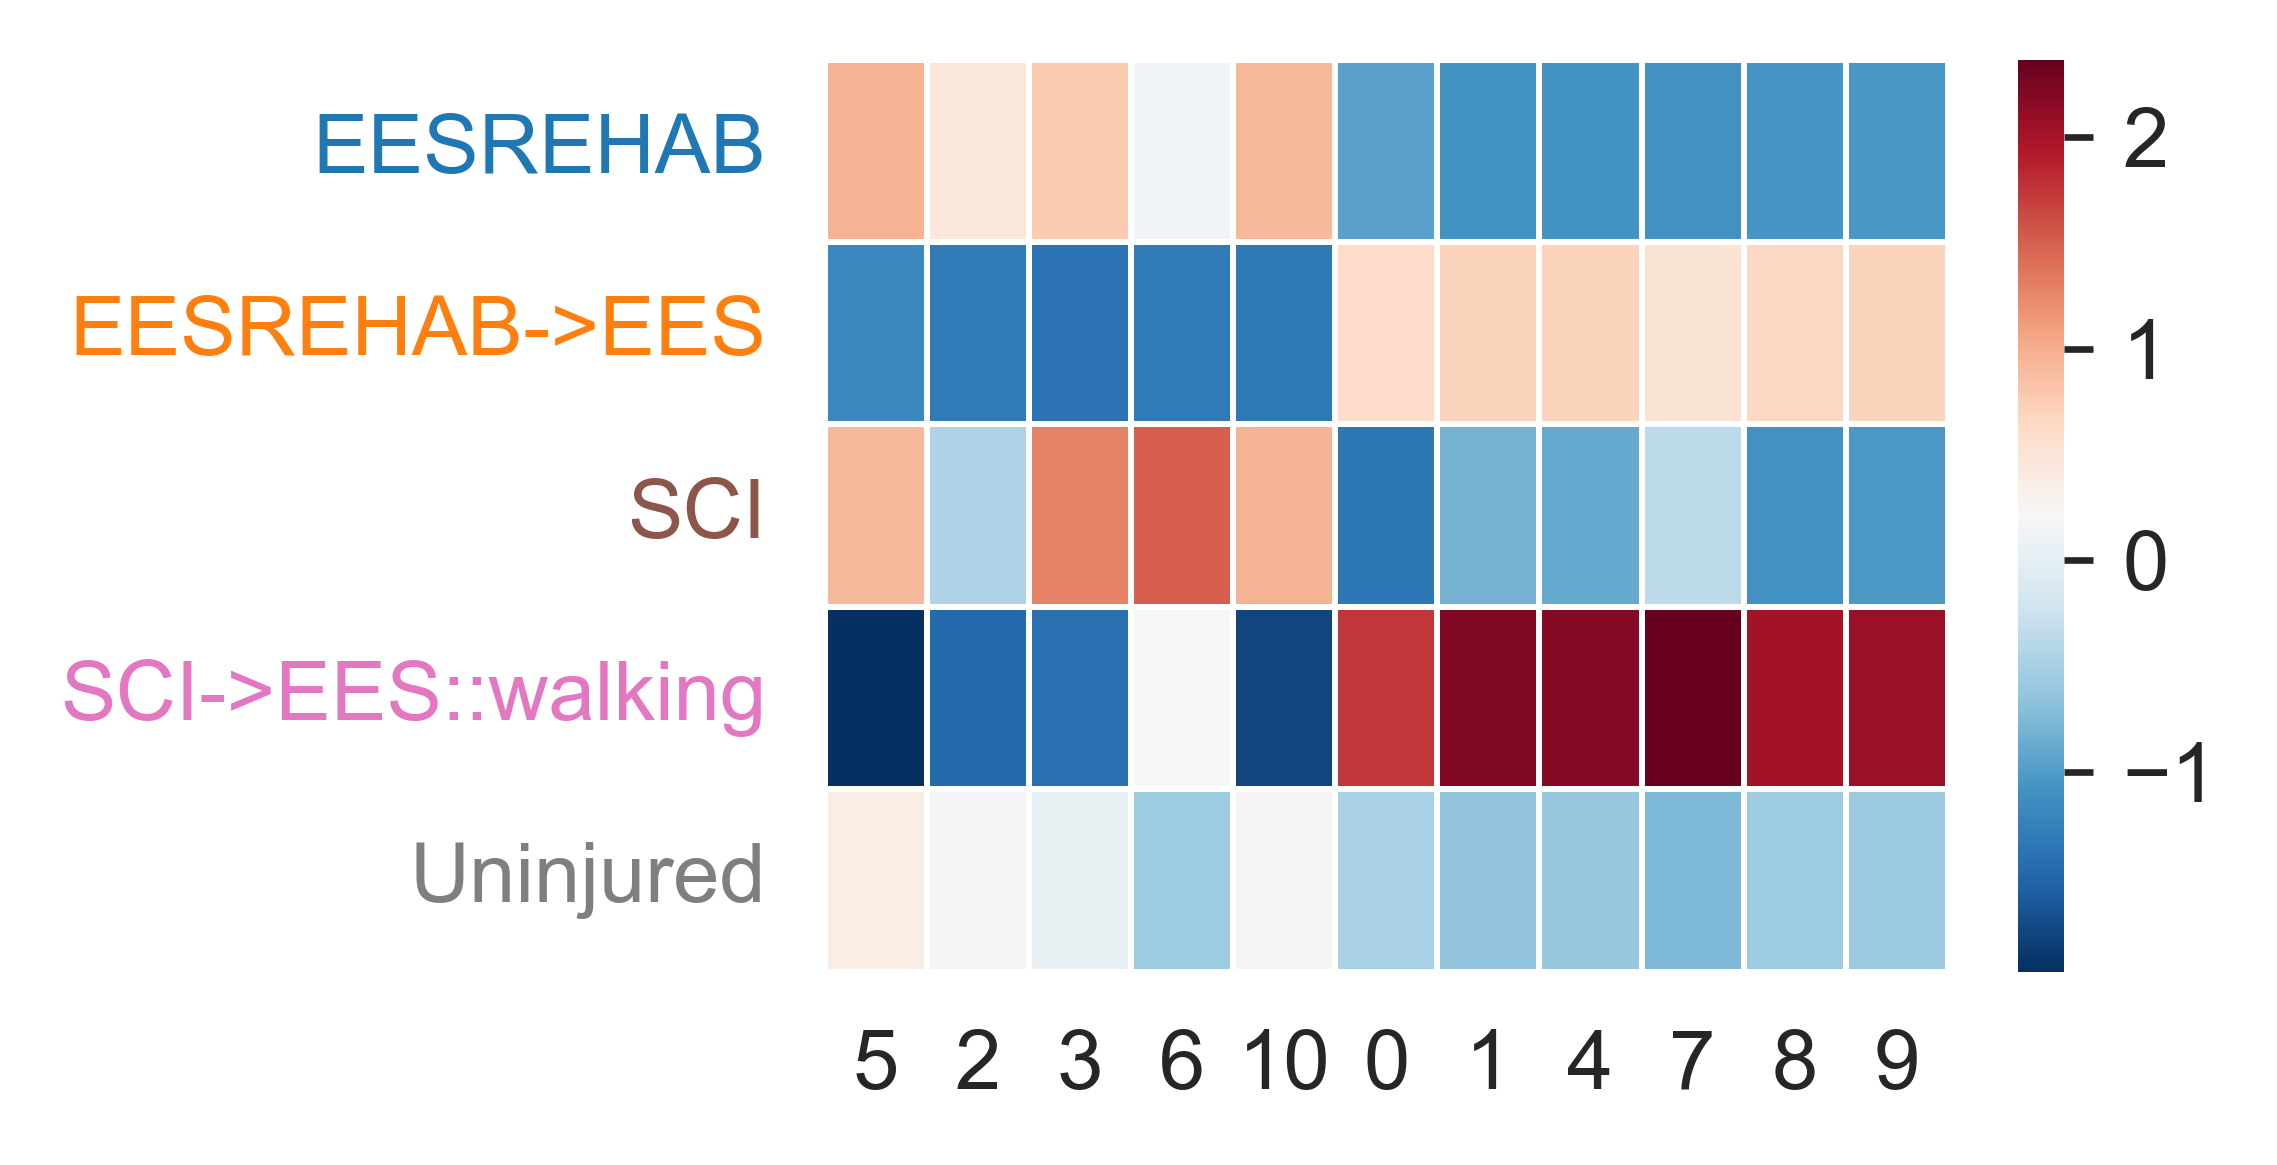

In [391]:
with sns.axes_style('white'):
    fig = plt.figure(figsize=(3,2))
    sns.heatmap(df1.iloc[[0,1,5,6,7],:], xticklabels=True, lw=.5, cmap='RdBu_r')
    ax = plt.gca()

ax.set_ylabel('')
for tick in ax.get_xticklabels():
    tick.set_rotation(0)

for tick in ax.get_yticklabels():
    tick.set_color(lut[tick.get_text()])

In [ ]:
exp = adata1[:,adata1.var['highly_variable']].to_df()

exp['F_1'] = adata1.obs['F1']
exp['F_2'] = adata1.obs['F_2']

In [ ]:
corr = np.corrcoef(exp.values.T)

corr = pd.DataFrame(corr, index=exp.columns, columns=exp.columns)

In [ ]:
idx1 = corr['F_1'].sort_values(ascending=False).index

idx2 = corr['F_2'].sort_values(ascending=False).index

pd.DataFrame(idx1[1:51]).to_csv('Neuron_gs1.csv')

pd.DataFrame(idx2[1:51]).to_csv('Neuron_gs2.csv')

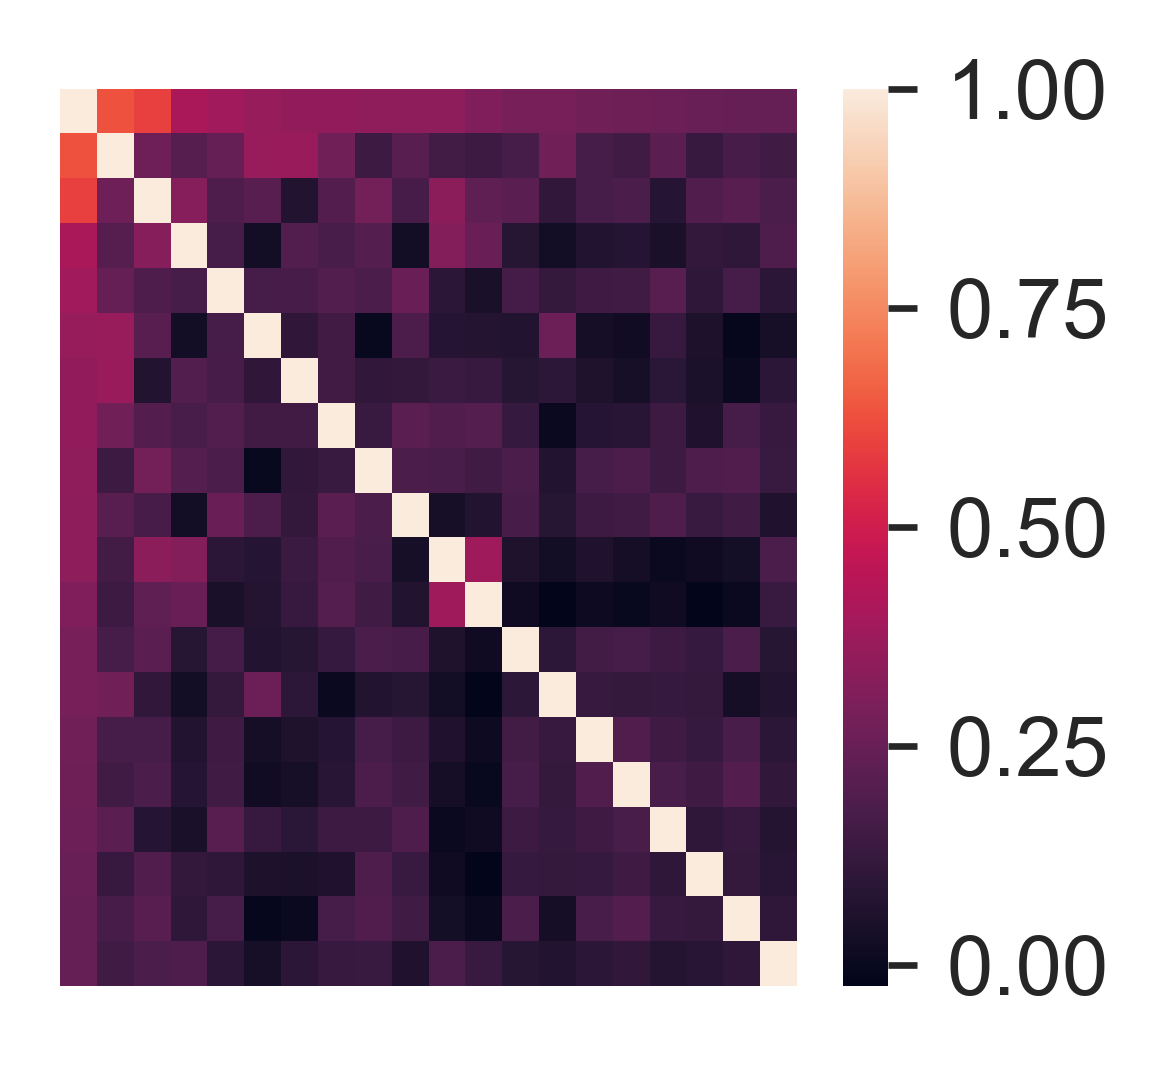

In [369]:
with sns.axes_style('white'):
    sns.heatmap(corr.loc[idx1,idx1].iloc[:20,:20])
    ax = plt.gca()
    ax.tick_params(labelleft=False,labelbottom=False)

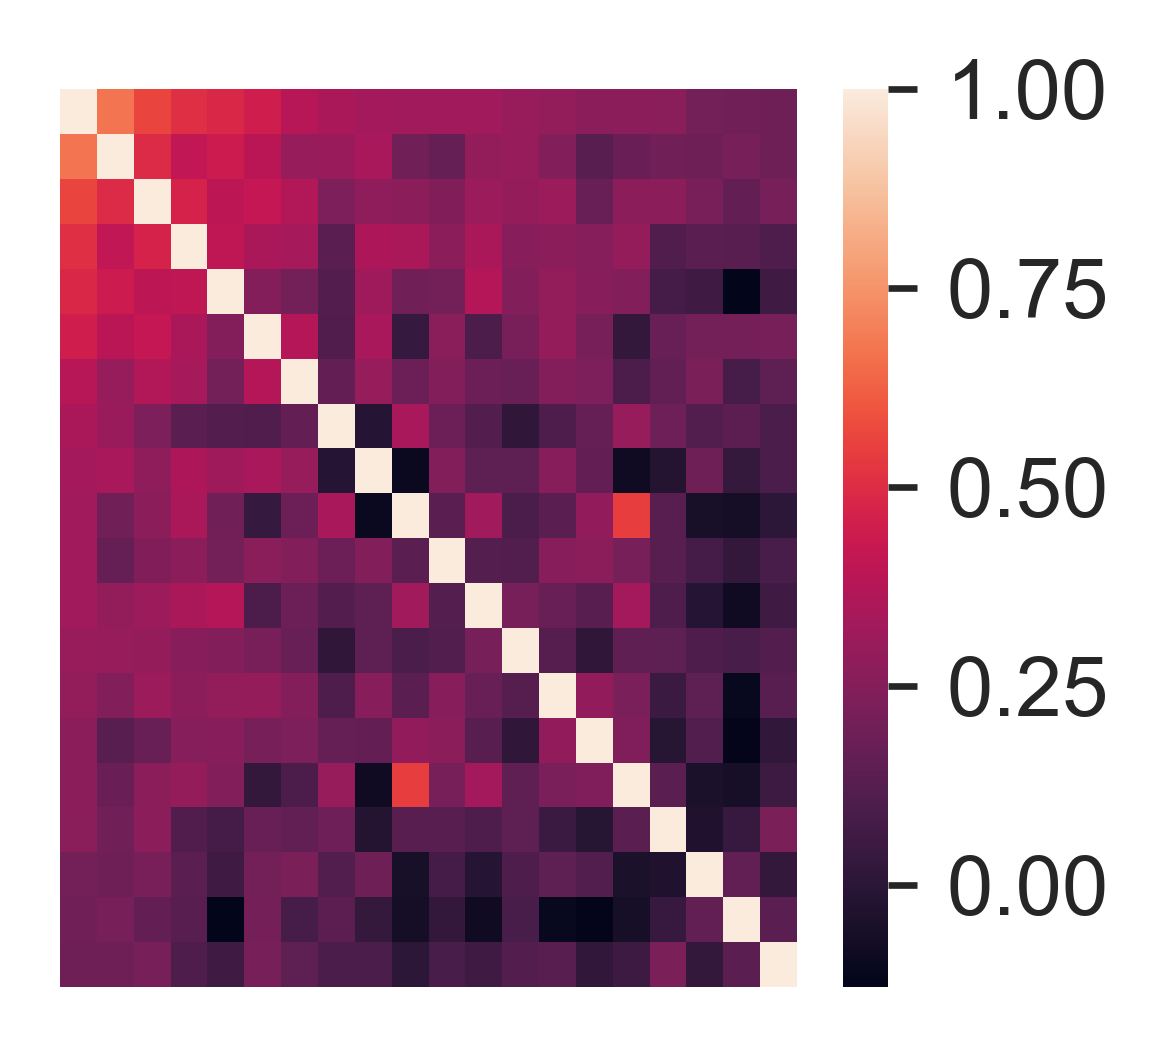

In [371]:
with sns.axes_style('white'):
    sns.heatmap(corr.loc[idx2,idx2].iloc[:20,:20])
    ax = plt.gca()
    ax.tick_params(labelleft=False,labelbottom=False)

In [372]:
idx1

Index(['F_1', 'Lrrtm4', 'Nrxn3', 'Gpc5', 'Cntn5', 'Galntl6', 'Mgat4c', 'Nrg1',
       'Cntnap2', 'Pde4d',
       ...
       'Cpne8', 'Sst', 'Ebf2', 'Ebf1', 'F_2', 'Mx1', 'Slamf8', 'Syt8', 'Tbx3',
       'Evi2a'],
      dtype='object', length=3994)

In [373]:
idx2

Index(['F_2', 'Ebf1', 'Ebf2', 'Sst', 'Arhgap6', 'Cpne8', 'Cntnap5c', 'Trpm3',
       'Pde11a', 'Tac2',
       ...
       'Cntnap2', 'Gpc5', 'Nrxn3', 'Lrrtm4', 'F_1', 'Mx1', 'Slamf8', 'Syt8',
       'Tbx3', 'Evi2a'],
      dtype='object', length=3994)

In [ ]:
adata1.obs['F_1_exp'] = adata1[:,['Lrrtm4', 'Nrxn3', 'Gpc5', 'Cntn5', 'Galntl6']].to_df().mean(axis=1)

adata1.obs['F_2_exp'] = adata1[:,['Ebf1', 'Ebf2', 'Sst', 'Arhgap6', 'Cpne8']].to_df().mean(axis=1)

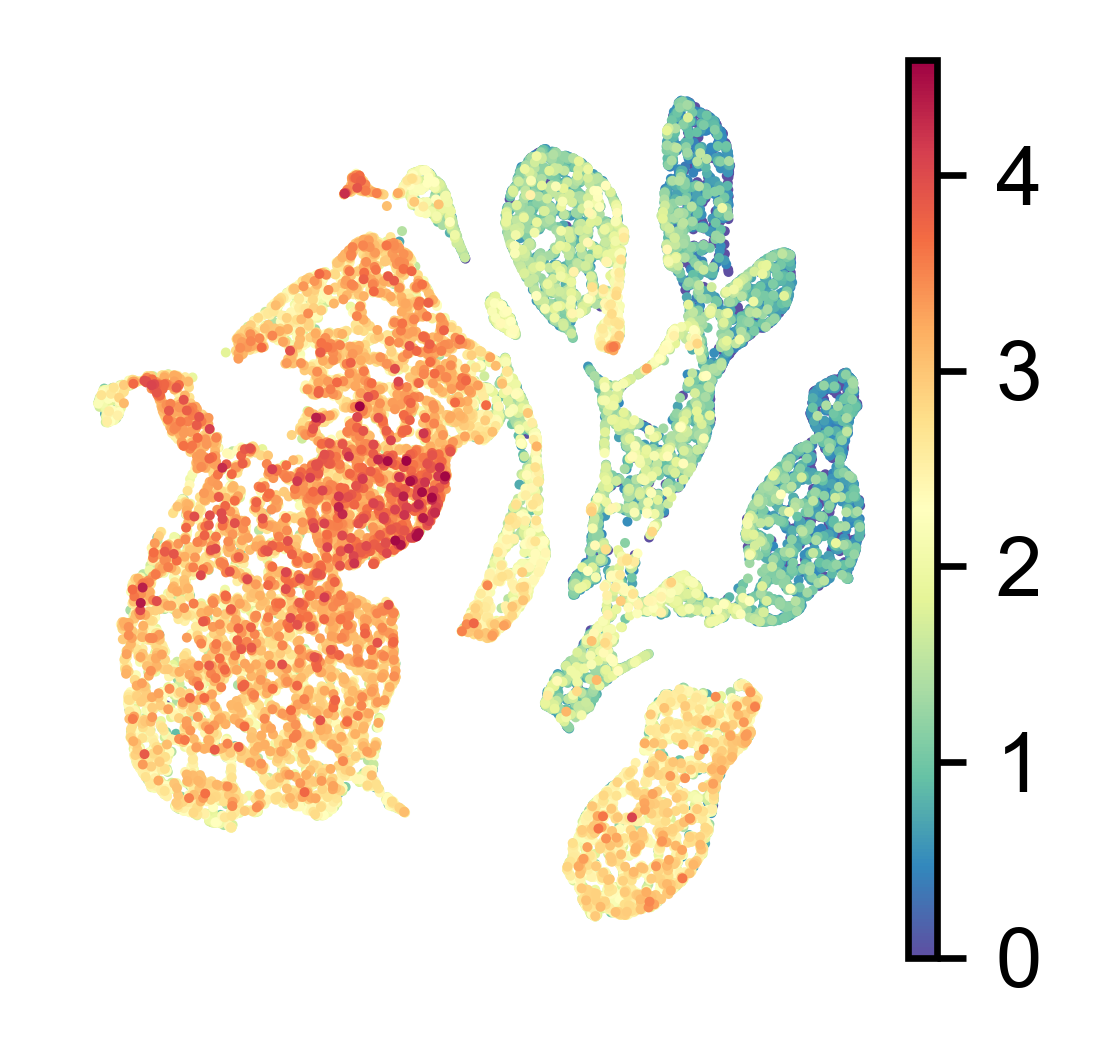

In [382]:
sc.pl.umap(adata1, color='F_1_exp',title='', cmap='Spectral_r')

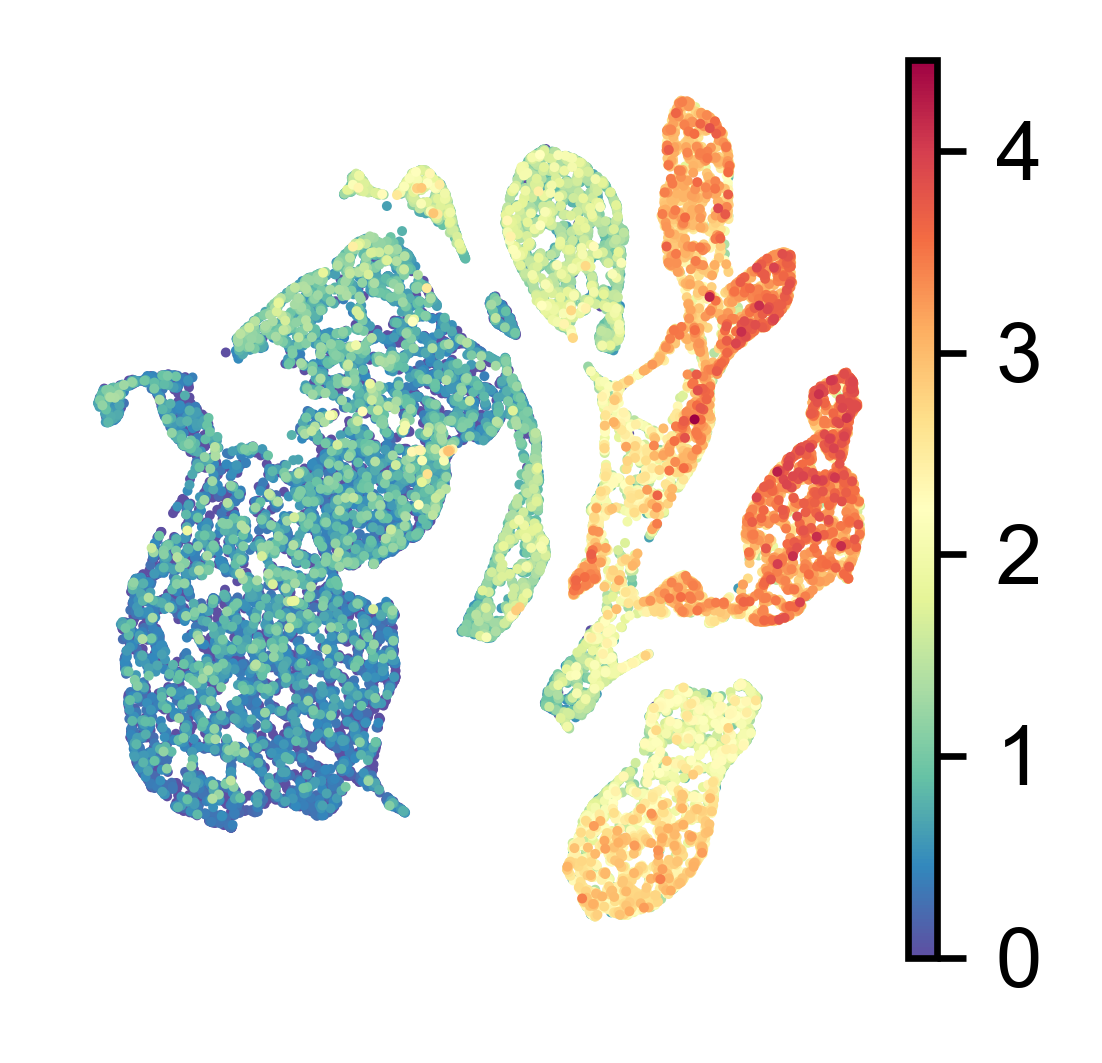

In [383]:
sc.pl.umap(adata1, color='F_2_exp',title='', cmap='Spectral_r')

In [390]:
joblib.dump(focus, 'Neurons_focus')

['Neurons_focus']

In [389]:
joblib.dump(adata1, 'Neurons')

['Neurons']

In [405]:
adata1

AnnData object with n_obs × n_vars = 20990 × 22806
    obs: 'replicate', 'label', 'global_cell_type', 'cell_type', 'batch', 'name_snn_res.0.1', 'name_snn_res.0.5', 'name_snn_res.1', 'name_snn_res.2', 'name_snn_res.3', 'name_snn_res.0.01', 'barcode', 'f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'F1', 'F_2', 'F_2_exp', 'F_1_exp'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'cell_type_colors', 'label_colors', 'global_cell_type_colors', 'rank_genes_groups', 'dendrogram_label'
    obsm: 'X_pca', 'X_umap', 'X_focus'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'